# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(100)
%load_ext autoreload
%autoreload 2

# Source Generation and Mixing Scenario

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.7, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = True)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

print("The following is the mixture matrix A")
display_matrix(A)

SNR = 40 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 36.524471574482526


# Visualize Generated Sources and Mixtures

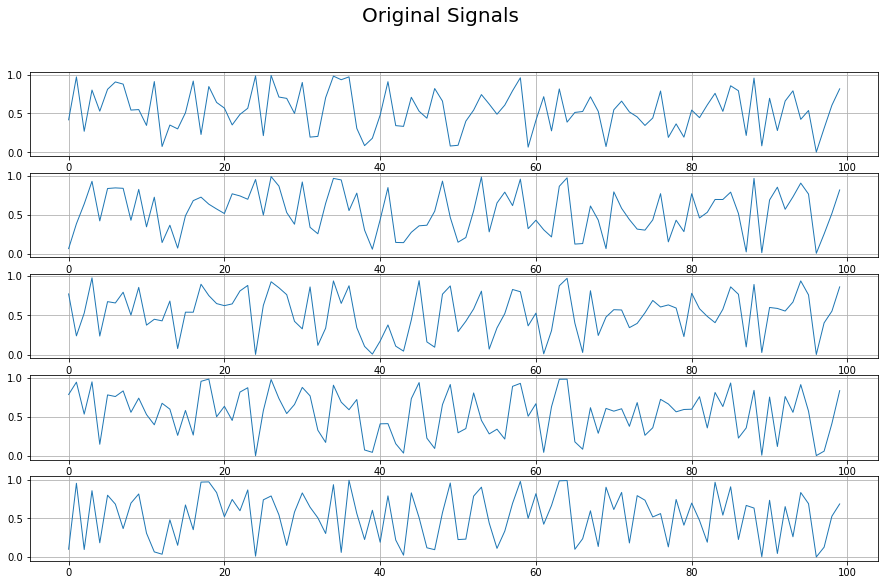

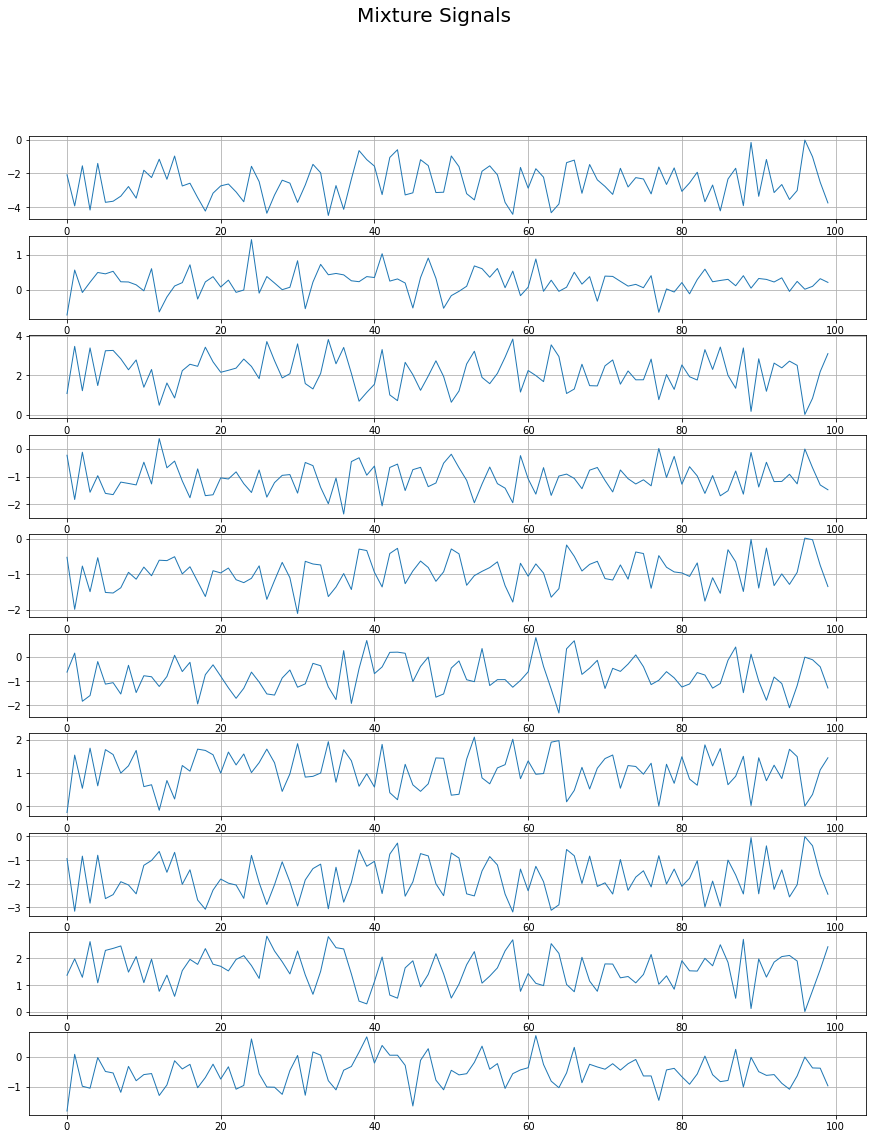

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
lambday = 1 - 1e-1/10
lambdae = 1 - 1e-1/3
beta = 30
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 1000 * np.eye(s_dim)

debug_iteration_point = 10000
model = OnlineLDMIBSS(s_dim = s_dim, x_dim = x_dim, muW = 30*1e-3, lambday = lambday,
                      lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                      set_ground_truth = True, S = S, A = A)

# Run CorInfoMax Algorithm on Mixture Signals

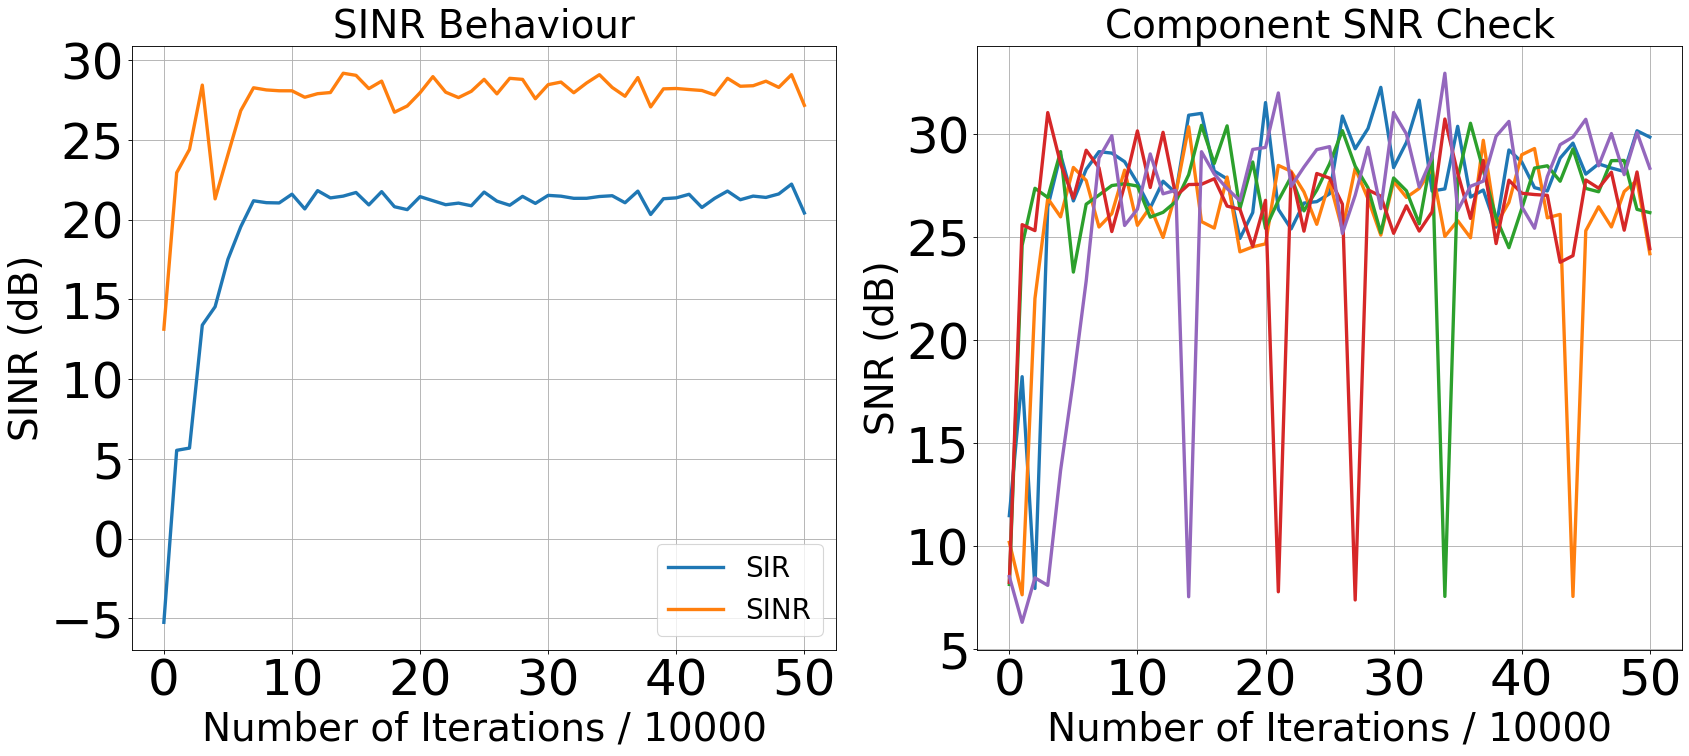

100%|██████████| 500000/500000 [02:09<00:00, 3861.60it/s]


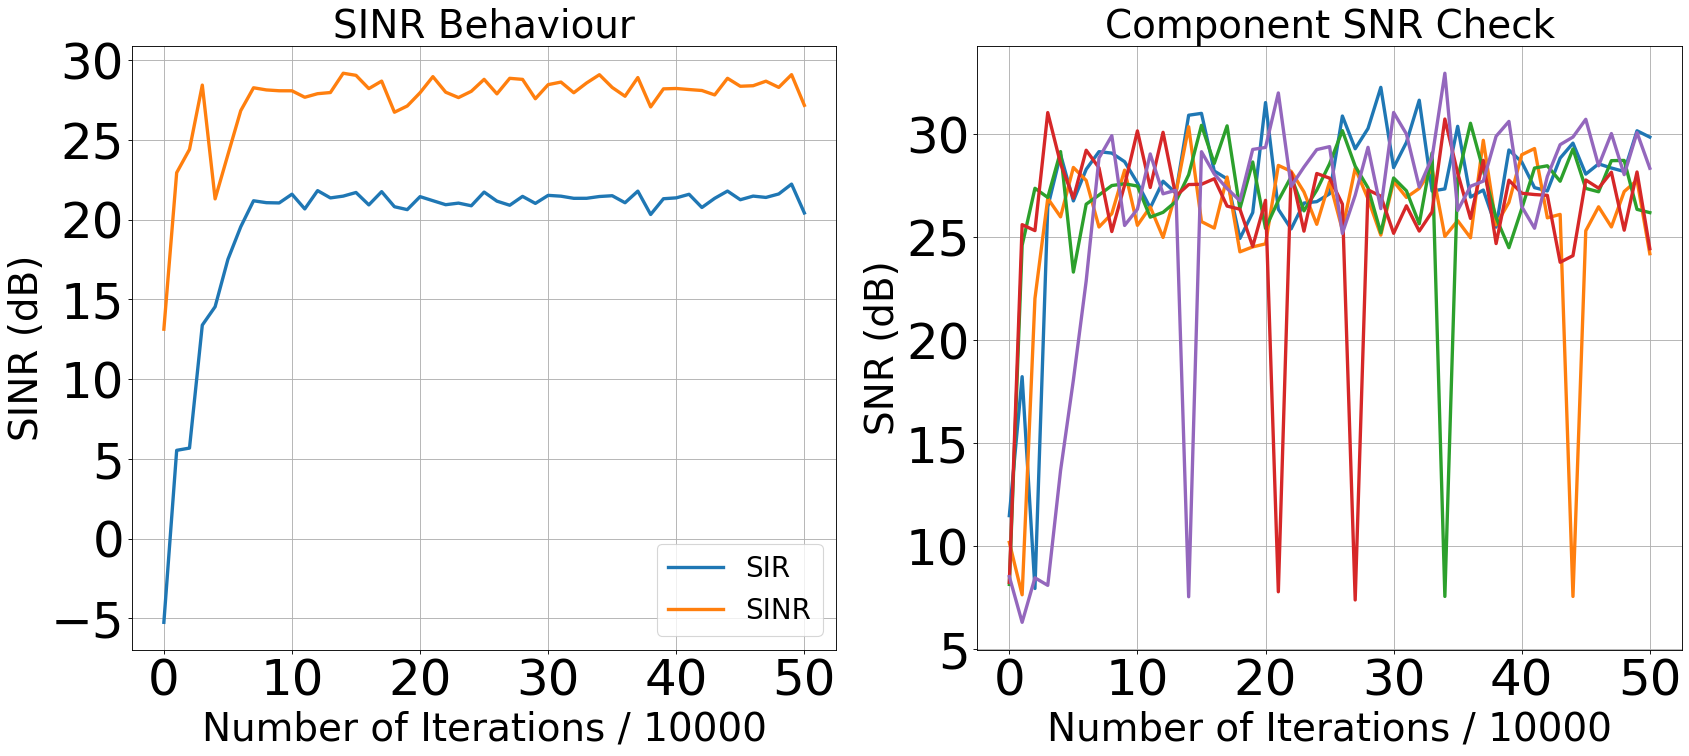

In [6]:
model.fit_batch_nnantisparse(X = X, n_epochs = 1, neural_dynamic_iterations = 500,
                           plot_in_jupyter = True, neural_lr_start = 0.9,
                           neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                           shuffle = True)

# Visualize SINR Convergence 

Final SIR: 27.163617709411987


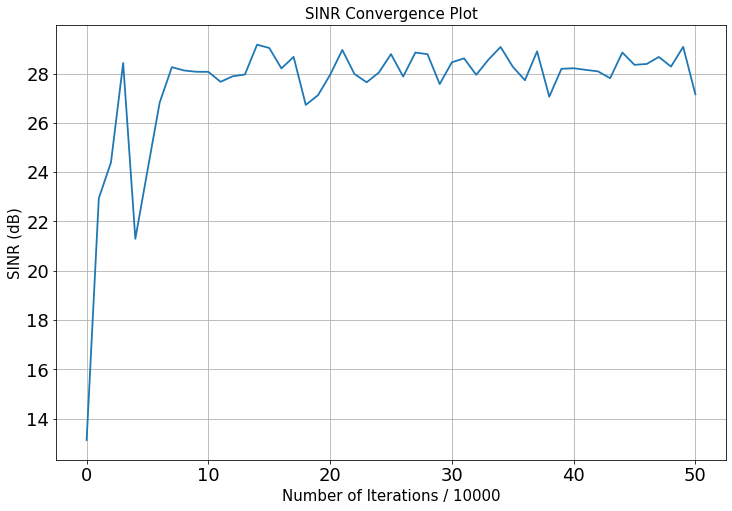

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SINR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SINR: {}'.format(np.array(model.SINR_list[-1])))

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Y_ = model.signed_and_permutation_corrected_sources(S.T,Y_.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINR = 10*np.log10(model.CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [29.86593611 24.2048986  26.19895903 24.44741271 28.354217  ]

Overall SINR : 27.163617709411987


# Vizualize Extracted Signals Compared to Original Sources

In [9]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = model.signed_and_permutation_corrected_sources(S.T,Y.T).T
Y_.shape, X.shape, S.shape

((5, 500000), (10, 500000), (5, 500000))

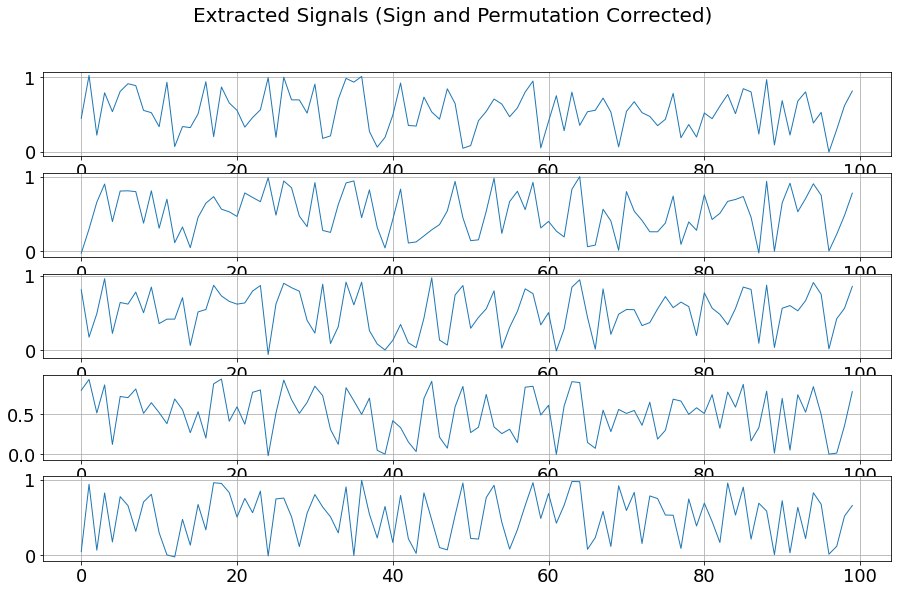

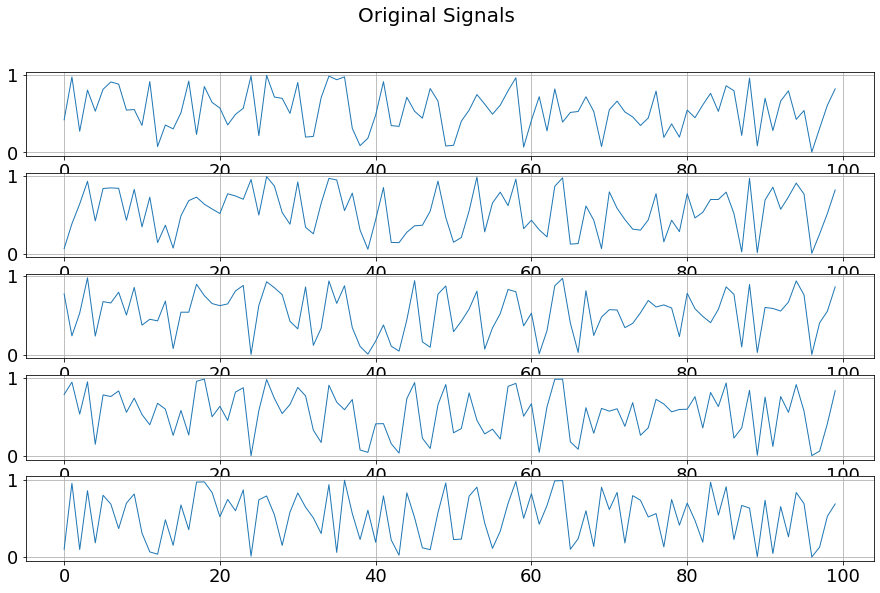

In [10]:
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)